# Notes for Possible Improvements
- Implementation of decoding instead of using pylibdmtx
    - Have not done yet due to complexity of it (even though it is deterministic algorithms)
    - Could possibly "steal" relevant parts from pylibdmtx or libdmtx and rewrite for this purpose
- Rewrites for squeezing out performance is possible
    - Avoiding later matrix inversion by assigning 1s and 0s in reverse
    - Avoiding multiple sorting by ensuring methods do not reorder points

# Setup

In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN
from collections import Counter

import os

import math

from pylibdmtx.pylibdmtx import decode

from ultralytics import YOLO

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Simple Helper Functions

In [2]:
# simple helper functions
def get_mode(lst):
    """Get the mode of a list."""
    return Counter(lst).most_common(1)[0][0]

def load_image_to_device(image_path):
    """Load an image to the device."""
    image = read_image(image_path).to(device) / 255.0  # Normalize to [0, 1]

    # if image has 4 channels, convert to 3 channels
    if image.shape[0] == 4:
        image = image[:3, :, :]

    return image.unsqueeze(0) # Add batch dimension

# YOLO Cropping

YOLO11n-obb summary (fused): 257 layers, 2,654,113 parameters, 0 gradients, 6.6 GFLOPs


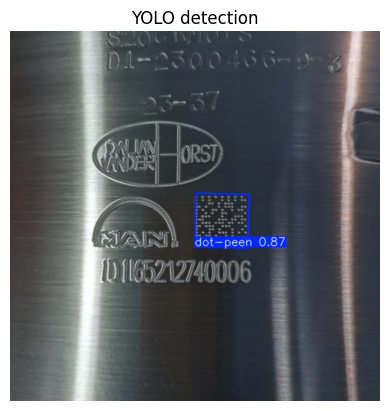

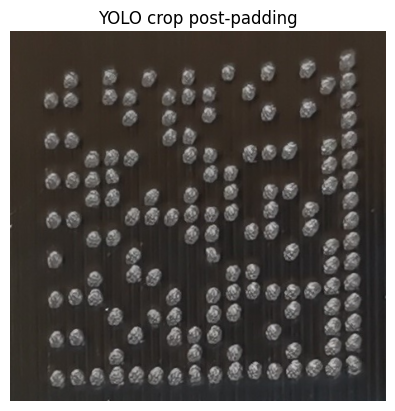

In [3]:
def load_yolo(model_path):
    """
    Load the YOLOv11 model from the specified path.

    Args:
        model_path (str): Path to the YOLOv11 model file.

    Returns:
        YOLO: The loaded YOLOv11 model.
    """
    model = YOLO(model_path)
    model.fuse()  # fuse model for faster inference
    model.eval()  # set model to evaluation mode
    return model

def yolo_detect(image, model, debug=False):
    """
    Detect object with highest confidence in an image using oriented YOLO.

    Args:
        image (torch.Tensor): The input image as a tensor.
        model (YOLO): The YOLOv11 model.
        debug (bool): If True, display the image with bounding box.

    Returns:
        list: xywhr bounding box for object detected in the image.
    """
    results = model.predict(image, verbose=False)

    if len(results) == 0:
        print("YOLO did not detect any objects.")
        return None

    result = results[0]
    if len(result.obb.xywhr) == 0:
        print("YOLO did not detect any objects.")
        return None
    
    if debug:
        result.save(filename='deleteme.jpg')
        debug_image = Image.open('deleteme.jpg')
        plt.imshow(debug_image)
        plt.axis('off')
        plt.title('YOLO detection')
        plt.show()
        os.remove('deleteme.jpg')

    return result.obb.xywhr[0]

def yolo_crop(image, xywhr, pad):
    """
    Crop the image using YOLOv11 oriented bounding box.

    Args:
        image (torch.Tensor): The input image as a tensor.
        xywhr (torch.Tensor): xywhr bounding box for object detected in the image.

    Returns:
        torch.Tensor: The cropped image.
        float: The padding applied to the image.
    """
    x, y, w, h, r = xywhr
    x, y, w, h, r = float(x), float(y), float(w), float(h), float(r)

    # padding by pad% of longest side
    pad = max(image.shape[2:]) * pad
    w_crop = int(w + 2 * pad)
    h_crop = int(h + 2 * pad)

    # image dimensions
    _, _, H, W = image.shape

    # normalize center to [-1, 1] (as required by affine_grid)
    cx = (2 * x / W) - 1
    cy = (2 * y / H) - 1

    # normalize width/height to [0, 2] (scale relative to image)
    sx = w_crop / W
    sy = h_crop / H

    # convert deg to rad and compute rotation matrix
    theta = r
    cos_t = math.cos(theta)
    sin_t = math.sin(theta)

    # build affine matrix (batch of 1)
    affine_matrix = torch.tensor([[
        [cos_t * sx, -sin_t * sy, cx],
        [sin_t * sx,  cos_t * sy, cy],
    ]], dtype=torch.float32, device=image.device)

    # creat grid and sample the image
    grid = F.affine_grid(affine_matrix, size=(1, image.shape[1], h_crop, w_crop), align_corners=False)
    cropped_image = F.grid_sample(image, grid, align_corners=False, padding_mode='zeros')

    return cropped_image

def yolo_detect_and_crop(image, model, pad, debug=False):
    """
    Detects an crops down to an object in the image using oriented YOLOv11.
    
    Args:
        image (torch.Tensor): The input image as a tensor.
        model (YOLO): The YOLOv11 model.
        debug (bool): If True, display the cropped image.
    
    Returns:
        torch.Tensor: The cropped image.
        float: The height of the bounding box.
        float: The width of the bounding box.
    """
    image_yolo = transforms.Resize((640, 640))(image.clone()) # resize image to 640x640

    # sometimes resize creates values above 1.0, so clamp to [0, 1]
    image_yolo = torch.clamp(image_yolo, 0, 1)

    with torch.no_grad():
        xywhr = yolo_detect(image_yolo, model, debug)

    if xywhr is None:
        print('WARNING, no object detected, returning original image')
        return image # return original image if no object detected

    # scale detection back to original image size
    _, _, H_orig, W_orig = image.shape

    scale_x = W_orig / 640
    scale_y = H_orig / 640

    x, y, w, h, r = [float(v) for v in xywhr]
    x *= scale_x
    y *= scale_y
    w *= scale_x
    h *= scale_y
    xywhr_scaled = torch.tensor([x, y, w, h, r], dtype=torch.float32, device=image.device)

    image = yolo_crop(image, xywhr_scaled, pad)

    if debug:
        image_tmp = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
        plt.imshow(image_tmp)
        plt.axis('off')
        plt.title('YOLO crop post-padding')
        plt.show()

    return image

# === load image ===
# train4 is original oriented YOLO no rotation lock
yolo_path = '../yolo/runs/obb/train4/weights/best.pt'
img_to_test = '../data/MAN/raw/train/1D1165212740006.jpeg'
image = load_image_to_device(img_to_test)

# === load & run YOLOv11 ===
yolo_path = '../yolo/runs/obb/train4/weights/best.pt'
pad = 0.01 # % to pad the yolo crop by
yolo_model = load_yolo(yolo_path)
image_yolo = yolo_detect_and_crop(image, yolo_model, pad, debug=True)

# Template Acquiring

## Model Definition

In [4]:
class DoubleConv(nn.Module):
    """(Conv → BN → ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class Down(nn.Module):
    """Downscaling with maxpool → double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.down(x)


class Up(nn.Module):
    """Upscaling → concat → double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, 2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # pad if needed
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_c=64):
        super().__init__()
        self.in_conv = DoubleConv(in_channels, base_c)
        self.down1 = Down(base_c, base_c * 2)
        self.down2 = Down(base_c * 2, base_c * 4)
        self.down3 = Down(base_c * 4, base_c * 8)
        self.down4 = Down(base_c * 8, base_c * 8)

        self.up1 = Up(base_c * 16, base_c * 4)
        self.up2 = Up(base_c * 8, base_c * 2)
        self.up3 = Up(base_c * 4, base_c)
        self.up4 = Up(base_c * 2, base_c)

        self.out_conv = nn.Conv2d(base_c, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        return torch.sigmoid(self.out_conv(x))

## Model Functions

In [5]:
def compute_retinex_reflectance_torch(img_tensor, sigma=30):
    """Reflectance extraction using Retinex algorithm."""
    eps = 1e-6
    img = img_tensor.clamp(min=eps) # avoids log(0) without shifting scale
    log_img = torch.log(img)

    def get_gaussian_kernel2d(kernel_size, sigma):
        ax = torch.arange(-kernel_size // 2 + 1., kernel_size // 2 + 1.).to(img_tensor.device)
        xx, yy = torch.meshgrid(ax, ax, indexing='ij')
        kernel = torch.exp(-(xx**2 + yy**2) / (2. * sigma**2))
        kernel = kernel / torch.sum(kernel)
        return kernel
    
    # approximate kernel size from sigma
    kernel_size = int(2 * math.ceil(3 * sigma) + 1)
    kernel = get_gaussian_kernel2d(kernel_size, sigma)
    kernel = kernel.to(img_tensor.device).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

    # apply gaussian blur to each channel
    channels = img_tensor.shape[1]
    kernel = kernel.expand(channels, 1, -1, -1) # [C, 1, kH, kW]
    blurred = F.conv2d(img_tensor, kernel, padding=kernel_size//2, groups=channels)
    blurred = blurred.clamp(min=eps) # avoids log(0) without shifting scale
    log_blur = torch.log(blurred)

    reflectance = log_img - log_blur

    def normalize(tensor):
        return (tensor - tensor.amin(dim=(1,2,3), keepdim=True)) / (tensor.amax(dim=(1,2,3), keepdim=True) + eps)

    # normalize to [0, 1]
    reflectance = normalize(reflectance)
    illumination = normalize(log_blur)

    return reflectance, illumination

YOLO11n-obb summary (fused): 257 layers, 2,654,113 parameters, 0 gradients, 6.6 GFLOPs


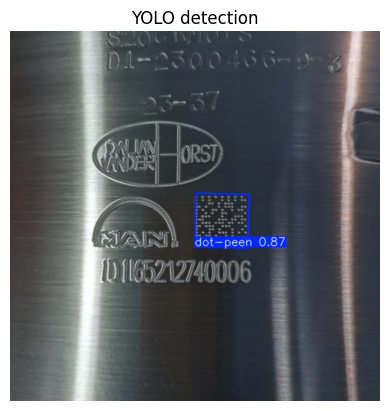

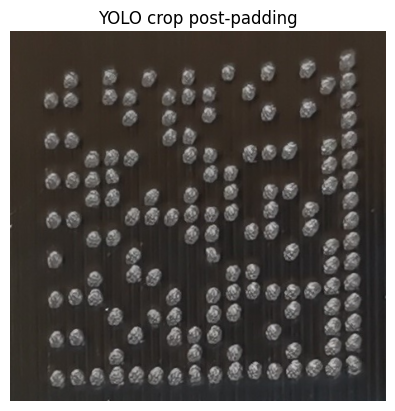

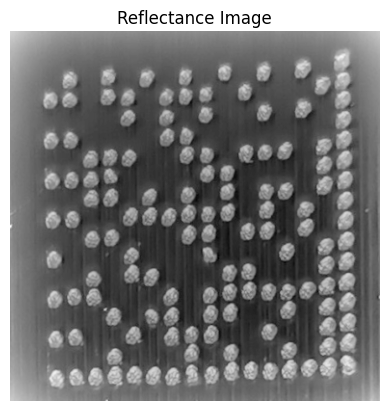

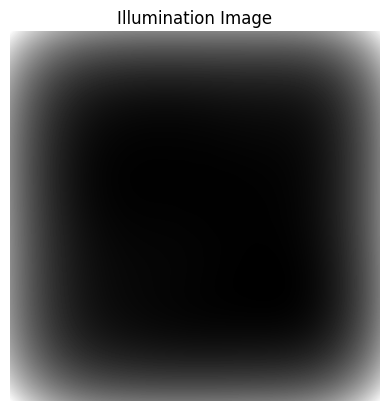

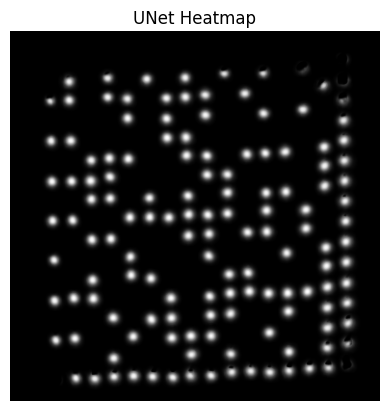

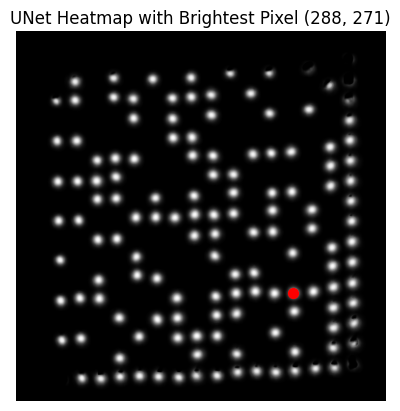

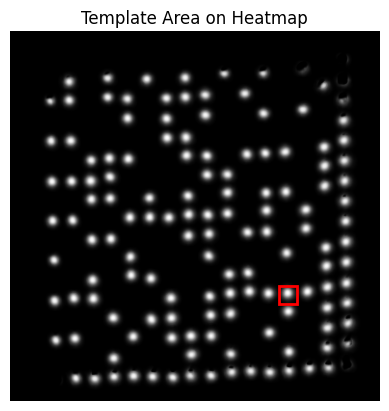

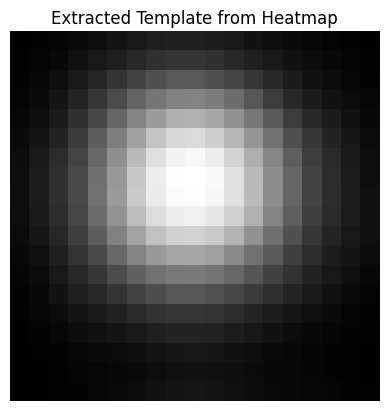

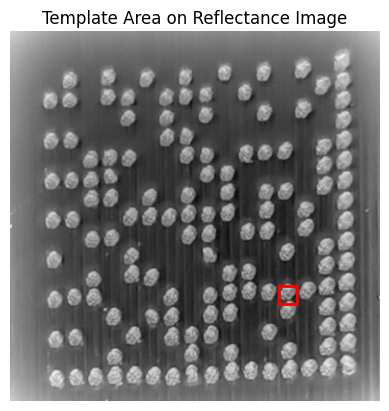

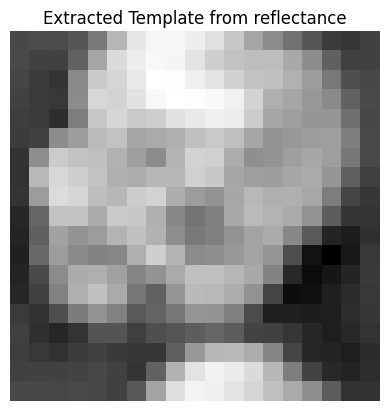

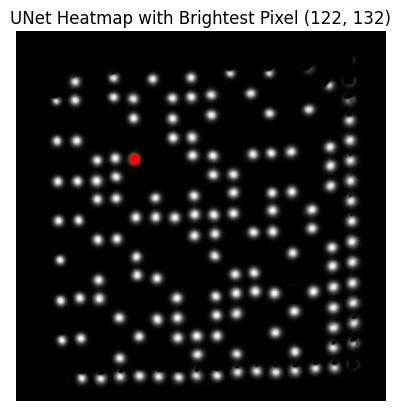

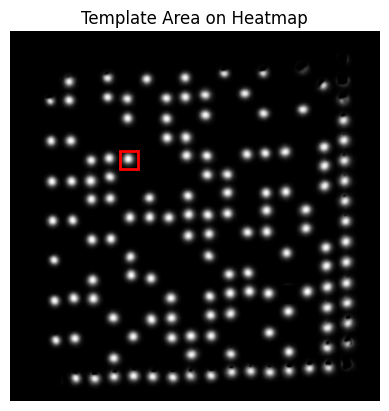

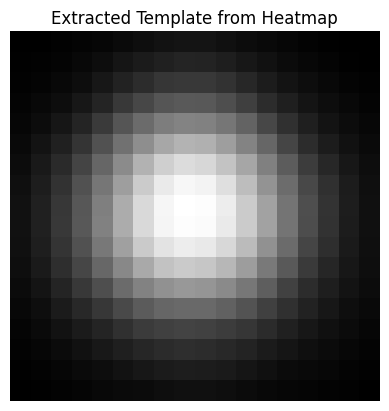

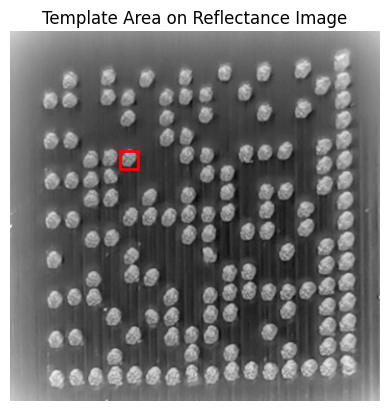

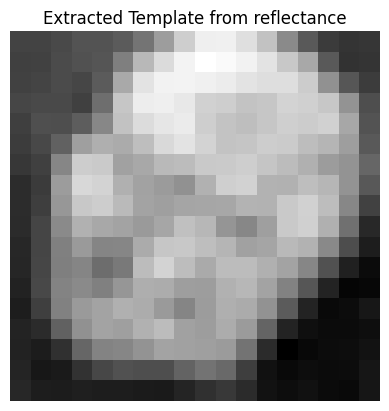

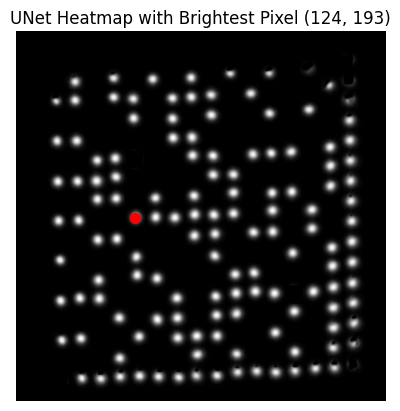

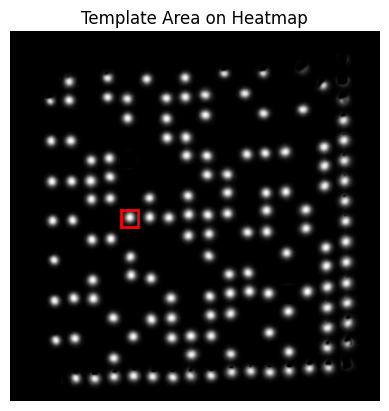

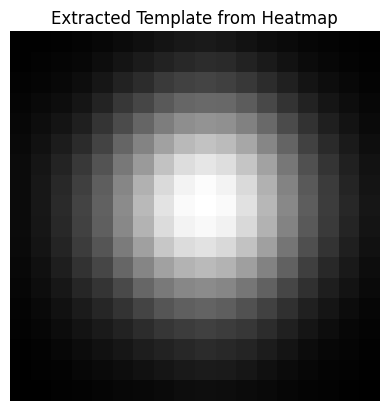

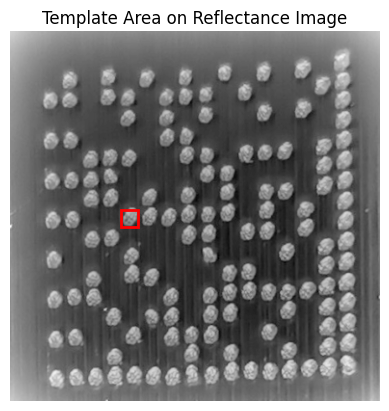

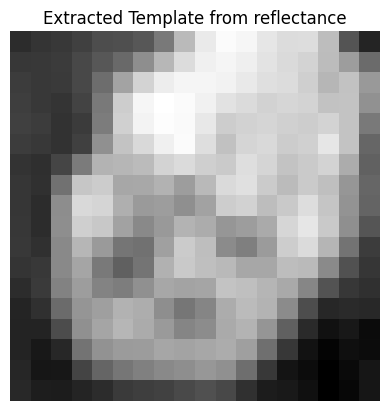

In [6]:
def load_unet(model_path):
    """
    Load the UNet model from the specified path.

    Args:
        model_path (str): Path to the UNet model file.

    Returns:
        UNet: The loaded UNet model.
    """
    # Load the model
    model = UNet(in_channels=1, out_channels=1).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # set model to evaluation mode
    return model

def unet_get_template(image_yolo, model, k_templates, debug=False):
    """
    Get the template from the image using UNet.

    Args:
        image_yolo (torch.Tensor): The input image as a tensor.
        h (float): Height of the YOLO bounding box.
        w (float): Width of the YOLO bounding box.
        model (UNet): The UNet model.
        debug (bool): Whether to show debug information.

    Returns:
        numpy.ndarray: The template extracted from the image.
    """
    # === prepare image for UNet ===
    image = transforms.Resize((384, 384), Image.BILINEAR)(image_yolo)
    image = transforms.Grayscale(num_output_channels=1)(image) # convert to grayscale
    reflectance, illumination = compute_retinex_reflectance_torch(image, sigma=50)

    if debug:
        reflectance_np = reflectance.squeeze().cpu().numpy()
        plt.imshow(reflectance_np, cmap='gray')
        plt.axis('off')
        plt.title('Reflectance Image')
        plt.show()

        illumination_np = illumination.squeeze().cpu().numpy()
        plt.imshow(illumination_np, cmap='gray')
        plt.axis('off')
        plt.title('Illumination Image')
        plt.show()

    # === get UNet heatmap ===
    with torch.no_grad():
        heatmap = model(reflectance)
    heatmap_np = heatmap.squeeze().cpu().numpy()
    if debug:
        plt.imshow(heatmap_np, cmap='gray')
        plt.axis('off')
        plt.title('UNet Heatmap')
        plt.show()

    # === get the templates from the heatmap ===
    templates = []
    for _ in range(k_templates):
        # selected from brightest pixel
        y, x = np.unravel_index(np.argmax(heatmap_np), heatmap_np.shape)

        if debug:
            plt.imshow(heatmap_np, cmap='gray')
            plt.scatter(x, y, color='red', s=50)
            plt.axis('off')
            plt.title(f'UNet Heatmap with Brightest Pixel ({x}, {y})')
            plt.show()

        # create binary mask around the pixel
        mask = np.zeros_like(heatmap_np, dtype=np.uint8)
        cv2.circle(mask, (x, y), radius=12, color=1, thickness=-1) # keep small region around the pixel
        local_heatmap = heatmap_np * mask
        threshold = np.max(local_heatmap) * 0.05 # can adjust (higher = smaller area)
        binary_mask = (local_heatmap >= threshold).astype(np.uint8)

        # optional: clean with morphological opening to remove noise
        kernel = np.ones((3, 3), np.uint8)
        binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)

        # get contour of bounding box
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            print("No contours found in the binary mask.")
            return None, None, None
        
        # choose largest contour
        largest_contour = sorted(contours, key=cv2.contourArea, reverse=True)[0]
        x, y, w_box, h_box = cv2.boundingRect(largest_contour)

        # clamp box size to expected dot size range (e.g. max 5% of image size)
        max_size = min(heatmap_np.shape) * 0.05
        side = int(min(max(w_box, h_box), max_size))

        # recenter bounding box around centroid (not top-left)
        M = cv2.moments(largest_contour)
        if M["m00"] == 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
        else:
            cx, cy = x + w_box // 2, y + h_box // 2

        # compute square bounds
        x1 = max(cx - side // 2, 0)
        y1 = max(cy - side // 2, 0)
        x2 = min(x1 + side, heatmap_np.shape[1])
        y2 = min(y1 + side, heatmap_np.shape[0])

        if debug:
            plt.imshow(heatmap_np, cmap='gray')
            plt.gca().add_patch(plt.Rectangle((x1, y1), side, side, edgecolor='red', facecolor='none', lw=2))
            plt.title("Template Area on Heatmap")
            plt.axis('off')
            plt.show()

            # extract the template from the heatmap
            template = heatmap_np[y1:y2, x1:x2]
            plt.imshow(template, cmap='gray')
            plt.title("Extracted Template from Heatmap")
            plt.axis('off')
            plt.show()

            # getting template from reflectance image
            template = reflectance.squeeze(0).permute(1, 2, 0).cpu().numpy()
            template = template[y1:y2, x1:x2]
            template = cv2.resize(template, (side, side)) # Resize to square

            if debug:
                plt.imshow(reflectance.squeeze(0).permute(1, 2, 0).cpu().numpy(), cmap='gray')
                plt.gca().add_patch(plt.Rectangle((x1, y1), side, side, edgecolor='red', facecolor='none', lw=2))
                plt.title("Template Area on Reflectance Image")
                plt.axis('off')
                plt.show()

                plt.imshow(template, cmap='gray')
                plt.title("Extracted Template from reflectance")
                plt.axis('off')
                plt.show()

        # extract the template from the reflectance image
        template = reflectance.squeeze(0).permute(1, 2, 0).cpu().numpy()
        template = template[y1:y2, x1:x2]
        template = template[:, :, 0] # (H, W, 1) -> (H, W)

        # if not square, resize to square
        if template.shape[0] != template.shape[1]:
            side = max(template.shape)
            template = cv2.resize(template, (side, side))

        # normalize template to [0, 255]
        template = ((template - np.min(template)) / (np.max(template) - np.min(template)) * 255).astype(np.uint8)
        
        # add template to list and remove from heatmap
        templates.append(template)
        heatmap_np[y1:y2, x1:x2] = 0

    # === post-process for use in template matching ===
    reflectance = reflectance.squeeze(0).permute(1, 2, 0).cpu().numpy() # (H, W, 1)
    reflectance = reflectance[:, :, 0] # remove extra channel
    illumination = illumination.squeeze(0).permute(1, 2, 0).cpu().numpy() # (H, W, 1)
    illumination = illumination[:, :, 0] # remove extra channel

    # normalize both to [0, 255]
    reflectance = ((reflectance - np.min(reflectance)) / (np.max(reflectance) - np.min(reflectance)) * 255).astype(np.uint8)

    return reflectance, illumination, templates

# === load image ===
img_to_test = '../data/MAN/raw/train/1D1165212740006.jpeg'
image = load_image_to_device(img_to_test)

# === get yolo crop ===
yolo_path = '../yolo/runs/obb/train4/weights/best.pt'
pad = 0.01 # % to pad the yolo crop by
yolo_model = load_yolo(yolo_path)
image_yolo = yolo_detect_and_crop(image, yolo_model, pad, debug=True)

# === get unet template ===
unet_path = '../models/dot_detection/checkpoints/unet_best.pth'
unet_model = load_unet(unet_path)
reflectance, illumination, templates = unet_get_template(image_yolo, unet_model, k_templates=3, debug=True)

# Template Matching

In [7]:
def single_scale_retinex(image, sigma=30):
    """
    Does single scale retinex on the input image.

    Args:
        image: Input image (numpy array)
        sigma: Gaussian kernel size (default is 30)
    
    Returns:
        Tuple of reflectance and illumination images
    """
    image = image.astype(np.float32) + 1.0
    illumination = cv2.GaussianBlur(image, (0, 0), sigma)
    illumination += 1.0
    reflectance = np.log(image) - np.log(illumination)
    reflectance_display = cv2.normalize(reflectance, None, 0, 255, cv2.NORM_MINMAX)
    reflectance_display = reflectance_display.astype(np.uint8)
    illumination_display = cv2.normalize(illumination, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return reflectance_display, illumination_display

In [8]:
def non_max_suppression_fast(boxes, scores, overlap_thresh=0.3):
    """
    Perform non-maximum suppression on the bounding boxes.

    Args:
        boxes: List of bounding boxes (x, y, width, height)
        scores: List of scores for each bounding box
        overlap_thresh: Overlap threshold for suppression (default is 0.3)
    
    Returns:
        List of bounding boxes after non-maximum suppression
    """
    if len(boxes) == 0:
        return []
    boxes = np.array(boxes)
    scores = np.array(scores)
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = scores.argsort()[::-1]
    keep = []
    while len(idxs) > 0:
        i = idxs[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[idxs[1:]])
        yy1 = np.maximum(y1[i], y1[idxs[1:]])
        xx2 = np.minimum(x2[i], x2[idxs[1:]])
        yy2 = np.minimum(y2[i], y2[idxs[1:]])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        inter = w * h
        overlap = inter / (areas[i] + areas[idxs[1:]] - inter)
        idxs = idxs[1:][overlap < overlap_thresh]
    return boxes[keep]

In [9]:
def extract_dominant_dot_template(image, min_area=20, max_area=300, patch_size=(24, 24), offset=5, size_tol=0.5):
    """
    Extracts the dominant dot template from the image.
    The function applies a series of image processing techniques to identify and extract the dot template.

    Args:
        image: Input image (numpy array)
        min_area: Minimum area of the dot to be considered (default is 20)
        max_area: Maximum area of the dot to be considered (default is 300)
        patch_size: Size of the patch to be extracted (default is (24, 24))
        offset: Offset for bounding box around the detected dot (default is 5)
        size_tol: Tolerance for size consistency (default is 0.5)

    Returns:
        Tuple of the extracted patch and contours of the detected dots.
    
    Raises:
        ValueError: If no valid dot candidates are found or if no size-consistent patches are found.
    """
    image_clean = cv2.bilateralFilter(image, d=15, sigmaColor=50, sigmaSpace=5)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image_clean = clahe.apply(image_clean)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (16, 16))
    tophat = cv2.morphologyEx(image_clean, cv2.MORPH_BLACKHAT, kernel)

    _, binary_top = cv2.threshold(tophat, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary_top, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    candidates = []
    sizes = []
    img_w, img_h = image.shape

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if min_area < area < max_area:
            x, y, w, h = cv2.boundingRect(cnt)
            crop_x_start = x - offset
            crop_x_end = x + w + offset
            crop_y_start = y - offset
            crop_y_end = y + h + offset

            if crop_x_start < 0 or crop_x_end >= img_w or crop_y_start < 0 or crop_y_end >= img_h:
                continue

            patch = image[crop_y_start:crop_y_end, crop_x_start:crop_x_end]
            candidates.append((patch, h, w))
            sizes.append((h, w))

    if not candidates:
        raise ValueError("No valid dot candidates found.")

    # Compute median size
    heights = [s[0] for s in sizes]
    widths = [s[1] for s in sizes]
    median_area = np.median(heights) * np.median(widths)

    # Keep only patches with similar size
    patches_filtered = []
    resized_for_matching = []
    for (patch, h, w) in candidates:
        # print(abs(h * w - median_area))
        if abs(h * w - median_area) / median_area < size_tol:
            patches_filtered.append(patch)
            resized_for_matching.append(cv2.resize(patch, patch_size))

    if not patches_filtered:
        raise ValueError("No size-consistent patches found.")

    # Find patch closest to the median template
    stack = np.stack(resized_for_matching, axis=0).astype(np.float32)
    median_template = np.median(stack, axis=0)
    diffs = [np.linalg.norm(p.astype(np.float32) - median_template) for p in resized_for_matching]
    best_idx = np.argmin(diffs)

    return patches_filtered[best_idx], contours

In [10]:
def template_matching(reflectance, template, method, match_thresh=0.7, nms_thresh=0.3):
    """
    Perform template matching to find the best match for the template in the reflectance image.

    Args:
        reflectance: Input reflectance image (numpy array)
        templates: Template image (numpy array)
        method: Method for template matching (default is cv2.TM_CCOEFF_NORMED)
        match_thresh: Threshold for template matching (default is 0.7)
        nms_thresh: Threshold for non-maximum suppression (default is 0.3)

    Returns:
        List of bounding boxes for the detected matches.
    """
    # === Template matching ===
    result = cv2.matchTemplate(reflectance, template, method)
    locations = zip(*np.where(result >= match_thresh)[::-1])
    scores = result[result >= match_thresh].flatten()

    # === Bounding boxes (x, y, w, h) for each match ===
    h, w = template.shape
    boxes = [(int(x), int(y), w, h) for (x, y) in locations]

    # === Apply NMS ===
    nms_boxes = non_max_suppression_fast(boxes, scores, overlap_thresh=nms_thresh)

    return nms_boxes

In [11]:
def contours_from_patch(patch):
    """
    Extracts contours from supplied patch image.
    """
    _, binary_patch = cv2.threshold(patch, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary_patch, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

In [12]:
def hu_descriptor(patch):
    """
    Computes Hu moments for a given patch.

    Args:
        patch: Input patch (numpy array)
    
    Returns:
        Hu moments of the patch (numpy array)
    """
    contours = contours_from_patch(patch)
    if not contours:
        return np.zeros(7)
    largest_contour = max(contours, key=cv2.contourArea)
    moments = cv2.moments(largest_contour)
    hu_moments = cv2.HuMoments(moments).flatten()
    return -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)

def select_diverse_templates(candidates, k):
    """
    Selects k diverse templates from the candidates using greedy farthest-point sampling.

    Args:
        candidates: List of candidate patches (numpy arrays)
        k: Number of templates to select
    
    Returns:
        List of selected templates (numpy arrays)
    """
    selected = [candidates[0]]
    selected_ids = {id(candidates[0])}

    while len(selected) < k and len(selected) < len(candidates):
        remaining = [c for c in candidates if id(c) not in selected_ids]
        if not remaining:
            break
        best = max(
            remaining,
            key=lambda c: min(np.linalg.norm(c[0] - s[0]) for s in selected)
        )
        selected.append(best)
        selected_ids.add(id(best))

    return [s[1] for s in selected] # return patches only

def remove_outlier_boxes(boxes, eps=50, min_samples=3):
    """
    Removes outlier boxes if they are too far from the main cluster of boxes.

    Args:
        boxes: List of bounding boxes (x, y, width, height)
    
    Returns:
        List of bounding boxes after removing outliers
    """
    centers = np.column_stack((boxes[:, 0] + boxes[:, 2] / 2,
                               boxes[:, 1] + boxes[:, 3] / 2))
    
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(centers)
    labels = clustering.labels_

    # keep only boxes from the largest cluster (label >= 0)
    valid_labels = labels[labels >= 0]
    if len(valid_labels) == 0:
        return boxes.tolist() # fallback: keep all
    main_cluster = np.argmax(np.bincount(valid_labels))
    keep_indices = np.where(labels == main_cluster)[0]

    return boxes[keep_indices].tolist()

def cascade_template_matching(reflectance, templates, method, match_thresh=0.7, nms_thresh=0.3, k_templates=4, debug=False):
    """
    Performs template matching repeatedly using new matches as templates until enough matches found.

    Args:
        reflectance: Input reflectance image (numpy array)
        templates: List of template images (numpy arrays)
        method: Method for template matching (default is cv2.TM_CCOEFF_NORMED)
        match_thresh: Threshold for template matching (default is 0.7)
        nms_thresh: Threshold for non-maximum suppression (default is 0.3)
        debug: If True, display debug information (default is False)

    Returns:
        List of bounding boxes for the detected matches.
    """
    # Initial template matchings
    initial_boxes = []
    for template in templates:
        matches = template_matching(reflectance, template, method, match_thresh, nms_thresh)
        initial_boxes.extend(matches)
    if len(initial_boxes) == 0:
        raise ValueError("No matches found in initial template matching.")
    
    # === Apply NMS to the initial boxes ===
    all_scores = [1] * len(initial_boxes) # optionally use actual scores
    initial_boxes = np.array(initial_boxes)
    initial_boxes = non_max_suppression_fast(initial_boxes, all_scores, overlap_thresh=nms_thresh)

    h, w = template.shape
    candidates = []
    for box in initial_boxes:
        x, y, bw, bh = box
        patch = reflectance[y:y + bh, x:x + bw]
        # resize patch to original template size
        if patch.shape != template.shape:
            patch = cv2.resize(patch, (w, h), interpolation=cv2.INTER_AREA)
        descriptor = hu_descriptor(patch)
        candidates.append((descriptor, patch, box))

    if len(candidates) < k_templates:
        k_templates = len(candidates)
    
    # select k diverse templates from the candidates
    diverse_templates = select_diverse_templates(candidates, k_templates)

    # accumulate boxes from new templates
    all_boxes = list(initial_boxes)
    for new_template in diverse_templates:
        matches = template_matching(reflectance, new_template, method, match_thresh, nms_thresh)
        all_boxes.extend(matches)
    all_boxes = np.array(all_boxes)

    # Apply NMS to the new boxes
    all_scores = [1] * len(all_boxes) # optionally use actual scores
    final_boxes = non_max_suppression_fast(all_boxes, all_scores, overlap_thresh=nms_thresh)

    # Remove outlier boxes
    final_boxes = remove_outlier_boxes(final_boxes)

    return final_boxes

In [13]:
def display_image(image, size=(300, 300)):
    """
    Displays the numpy image using PIL and notebook display functionality.

    Args:
        image: Input image (numpy array)
        size: Size to which the image should be resized (default is (300, 300))
    
    Returns:
        None
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, size)
    pil_image = Image.fromarray(image)
    display(pil_image)

In [14]:
def display_yucheng_methods(nms_boxes, reflectance, img, illumination, template_A, template_B):
    """
    Displays the results of Yuchengs methods for dot detection and template matching.

    Args:
        nms_boxes: List of bounding boxes after non-maximum suppression
        reflectance: Reflectance map (numpy array)
        dot_contours: Contours of the detected dots
        img: Original image (numpy array)
        illumination: Estimated illumination (numpy array)
        dot_template: Dot template (numpy array)
    
    Returns:
        None
    """
    # === Draw matching result ===
    output = cv2.cvtColor(reflectance, cv2.COLOR_GRAY2BGR)
    for (x, y, w, h) in nms_boxes:
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # === Show results ===
    fig, axs = plt.subplots(2, 3, figsize=(10, 6))
    axs[0, 0].imshow(img, cmap='gray')
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis("off")

    axs[0, 1].imshow(illumination, cmap='gray')
    axs[0, 1].set_title("Estimated Illumination")
    axs[0, 1].axis("off")

    axs[0, 2].imshow(reflectance, cmap='gray')
    axs[0, 2].set_title("Reflectance Map (SSR)")
    axs[0, 2].axis("off")

    axs[1, 0].imshow(cv2.cvtColor(template_A, cv2.COLOR_BGR2RGB))
    axs[1, 0].set_title("Template A")
    axs[1, 0].axis("off")

    axs[1, 1].imshow(template_B, cmap='gray')
    axs[1, 1].set_title("Template B")
    axs[1, 1].axis("off")

    axs[1, 2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[1, 2].set_title("Template matching")
    axs[1, 2].axis("off")

    plt.tight_layout()
    plt.show()

## Yucheng Use

YOLO11n-obb summary (fused): 257 layers, 2,654,113 parameters, 0 gradients, 6.6 GFLOPs


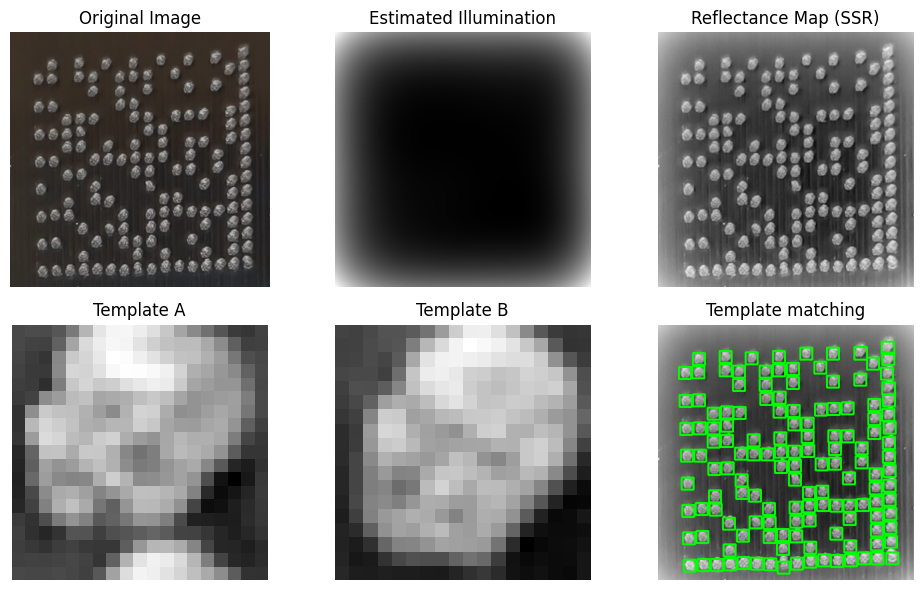

In [15]:
# === load image ===
img_to_test = '../data/MAN/raw/train/1D1165212740006.jpeg'
image = load_image_to_device(img_to_test)

# === get yolo crop ===
yolo_path = '../yolo/runs/obb/train4/weights/best.pt'
pad = 0.01 # % to pad the yolo crop by
yolo_model = load_yolo(yolo_path)
image_yolo = yolo_detect_and_crop(image, yolo_model, pad)

# === get image and unet template ===
unet_path = '../models/dot_detection/checkpoints/unet_best.pth'
unet_model = load_unet(unet_path)
reflectance, illumination, templates = unet_get_template(image_yolo, unet_model, k_templates=3)

# === cascade template matching ===
nms_boxes = cascade_template_matching(reflectance, templates, cv2.TM_CCOEFF_NORMED, match_thresh=0.7, nms_thresh=0.3, k_templates=3, debug=True)

# === visualize results ===
display_yucheng_methods(nms_boxes, reflectance, image_yolo.squeeze(0).permute(1, 2, 0).cpu().numpy(), illumination, templates[0], templates[1])

# Grid Fitting

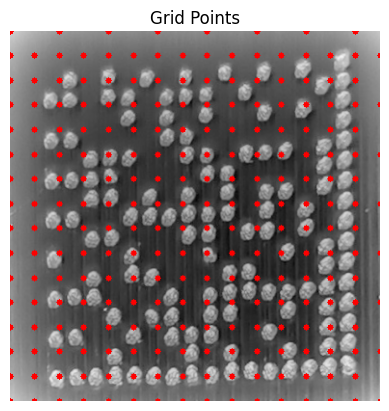

In [16]:
def generate_grid(params, grid_size=16):
    """
    Generates a grid of DMC points based on the given parameters.

    Args:
        x0: X coordinate of the center of the grid
        y0: Y coordinate of the center of the grid
        sx: Scale factor in the X direction
        sy: Scale factor in the Y direction
        theta: Rotation angle in radians
        grid_size: Size of the grid (default is 16)
    
    Returns:
        array of grid points (x, y) in the original coordinate system
    """
    x0, y0, sx, sy, theta = params

    # force sx and sy to be minimum of 1.0 (to avoid zero size)
    sx = max(sx, 1.0)
    sy = max(sy, 1.0)

    # building standard grid of DMC points (finder pattern + all inner points)
    coords = []
    for i in range(grid_size):
        for j in range(grid_size):
            # finder pattern specific points
            if 0 in [i, j] or grid_size - 1 in [i, j]: # points on the finder pattern
                if j == 0 and i in range(1, grid_size - 1, 2): # top timing pattern
                    continue
                elif i == grid_size - 1 and j in range(0, grid_size - 1, 2): # right timing pattern
                    continue
                else: # left and bottom finder pattern
                    coords.append([i, j])
            else: # inner points
                coords.append([i, j])
    coords = np.array(coords).astype(float)

    # center the grid around (0, 0)
    coords -= (grid_size - 1) / 2

    # Convert to original coordinate system
    coords = np.dot(coords, np.array([[sx, 0], [0, sy]])) # scale
    coords = np.dot(coords, np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])) # rotate
    coords += np.array([[x0, y0]]) # translate

    return coords

def inverse_grid_transform(grid_pts, params, grid_size=16):
    """
    Inverse transformation of the grid points to the original coordinate system.

    Args:
        grid_pts: Grid points to be transformed (numpy array)
        params: Parameters used for the transformation (x0, y0, sx, sy, theta)
        grid_size: Size of the grid (default is 16)

    Returns:
        array of grid points (x, y) in the dmc coordinate system
    """
    x0, y0, sx, sy, theta = params

    # force sx and sy to be minimum of 1.0 (same as in generate_grid)
    sx = max(sx, 1.0)
    sy = max(sy, 1.0)

    # undo translation
    grid_pts = grid_pts.astype(float)
    grid_pts -= np.array([[x0, y0]])

    # undo rotation
    rot_mat_inv = np.array([[np.cos(theta), np.sin(theta)],
                            [-np.sin(theta), np.cos(theta)]])
    grid_pts = np.dot(grid_pts, rot_mat_inv)

    # undo scaling
    grid_pts = np.dot(grid_pts, np.linalg.inv(np.diag([sx, sy])))

    # convert to standard grid coordinates
    grid_pts += (grid_size - 1) / 2

    # round to nearest integer
    grid_pts = np.rint(grid_pts).astype(int)

    # clip to valid range (to avoid errors)
    if np.any(grid_pts < 0) or np.any(grid_pts >= grid_size):
        print("Warning: one or more grid points are out of bounds!")
        grid_pts = np.clip(grid_pts, 0, grid_size - 1)

    return grid_pts


def show_grid(img, grid_pts, title="Grid Points"):
    """
    Shows the grid points on the image.

    Args:
        img: Input image (numpy array)
        grid_pts: Grid points to be displayed (numpy array)
        title: Title of the plot (default is "Grid Points")
    """
    img = img.copy() # to avoid modifying the original image
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Convert grayscale to BGR
    for p in grid_pts:
        # cv2.circle(img, (int(p[0]), int(p[1])), 3, (0, 255, 0), -1)
        cv2.circle(img, (int(p[0]), int(p[1])), 3, (0, 0, 255), -1) # red color for grid points
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

# === Example usage of grid generation ===
img = reflectance

# params to cover entire image
img_size = img.shape[0]
params = [
    img_size / 2, # x0
    img_size / 2, # y0
    img_size / 15, # sx
    img_size / 15, # sy
    0.0 # theta
]
grid_pts = generate_grid(params)
show_grid(img, grid_pts)

Estimated x, y: (205.068345323741, 210.03956834532374)
Modal distance between (close) points: 20.0
Estimated sx & sy: 20.0, 20.0
Estimated theta: 1.62
Initial parameters: [205.068345323741, 210.03956834532374, 20.0, 20.0, 1.62]


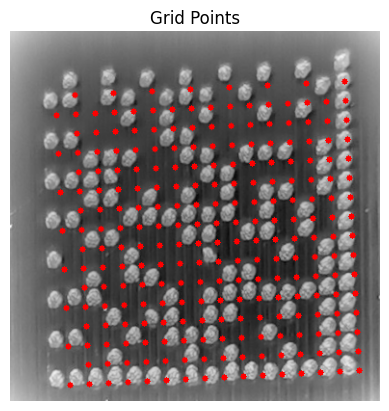

In [17]:
def estimate_grid_params(nms_boxes, debug=False):
    """
    Estimates grid starting parameters using the observed points from the detected boxes.
    The function uses the observed points to compute the initial parameters for the affine transformation.
    """
    observed_pts = np.array([[x + w / 2, y + h / 2] for (x, y, w, h) in nms_boxes])

    # estimating reasonable x, y based on the average of all points
    x = np.mean(observed_pts[:, 0])
    y = np.mean(observed_pts[:, 1])
    if debug:
        print(f"Estimated x, y: ({x}, {y})")

    # getting mode distance between closest points for later usage
    distances = []
    for i in range(len(observed_pts)):
        closest_pt = float('inf')
        for j in range(i + 1, len(observed_pts)):
            if i != j:
                # find the closest point to i
                dist = np.linalg.norm(observed_pts[i] - observed_pts[j])
                if dist < closest_pt:
                    closest_pt = dist
        if closest_pt != float('inf'):
            distances.append(np.round(closest_pt, 2))
    # mode distance is used because we want the most common distance, not the average
    mod_dist = get_mode(distances)
    if debug:
        print(f"Modal distance between (close) points: {mod_dist}")

    # estimating sx & sy based on vectors of points and their closest "L" neighbors (points at distances of mod_dist or less)
    # simultaneously estimating theta based on the angle between the two vectors
    sxs = []
    sys = []
    thetas = []
    for i in range(len(observed_pts)):
        # find closest point to i
        dist_a = float('inf')
        a_idx = -1
        for j in range(i + 1, len(observed_pts)):
            dist = np.linalg.norm(observed_pts[i] - observed_pts[j])
            if dist < dist_a:
                dist_a = dist
                a_idx = j
                point_a = observed_pts[j]
                vec_a = observed_pts[j] - observed_pts[i]
        
        # find next closest point to i that forms a tight enough "L" shape with regards to first point
        # (i.e. the two points are orthogonal to each other from i)
        point_b = None
        for j in range(i + 1, len(observed_pts)):
            if j == a_idx:
                continue
            
            # check if vectors from point i to point_a and from i to point_b are orthogonal
            vec_b_tmp = observed_pts[j] - observed_pts[i]
            cos_angle = np.dot(vec_a, vec_b_tmp) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b_tmp) + 1e-8)
            angle_deg = np.degrees(np.arccos(np.clip(cos_angle, -1.0, 1.0)))
            if 80 <= angle_deg <= 100:
                # points i, a_idx, and j form an "L" shape!
                # now to make sure both points are close enough to i
                dist_b = np.linalg.norm(vec_b_tmp)
                if dist_a <= mod_dist*2 and dist_b <= mod_dist*2:
                    # point_b is close enough to i!
                    point_b = observed_pts[j]
                    vec_b = vec_b_tmp
                    # if debug:
                        # print(f"Found L shape: {observed_pts[i]} -> {point_a} -> {point_b}")
                        # print(f"Vectors: {vec_a}, {vec_b}")
                        # print(f"Distances: {np.linalg.norm(vec_a)}, {np.linalg.norm(vec_b)}")
        
        # if we found a point that is orthogonal to point_a, we can use it to estimate sx and sy
        if point_a is not None and point_b is not None:
            # stricter dist check for sx and sy than theta
            # we can use the distance between the points to estimate sx and sy
            if dist_a <= mod_dist and dist_b <= mod_dist:
                sx_a = np.linalg.norm(vec_a)
                sx_b = np.linalg.norm(vec_b)
                
                # round to 2 decimal places for consistent mode calculation
                sx_a = np.round(sx_a, 2)
                sx_b = np.round(sx_b, 2)

                # weird case where numpy differentiates between -0.0 and 0.0
                if sx_a == 0:
                    sx_a = 0
                if sx_b == 0:
                    sx_b = 0

                sxs.append(sx_a)
                sys.append(sx_b)
                
                # sxs.append(np.linalg.norm(vec_a))
                # sys.append(np.linalg.norm(vec_b))
            # we can also compare angle between the two vectors and default vector (0, 1)
            theta_a = np.arctan2(vec_a[1], vec_a[0]) - np.arctan2(0, 1)
            theta_b = np.arctan2(vec_b[1], vec_b[0]) - np.arctan2(0, 1)
            # for consistency, we want to use the angle of the vector that is closest to the default vector (0, 1)
            if abs(theta_a) < abs(theta_b):
                theta = theta_a
            else:
                theta = theta_b
            theta = np.round(theta, 2) # round to 2 decimal places for consistent mode calculation
            if theta == 0: # weird case where numpy differentiates between -0.0 and 0.0
                theta = 0
            thetas.append(-theta) # flipped angle
            # if debug:
            #     print(f"Angle: {theta}")

                # plot found L shapes
                # plt.plot([observed_pts[i][0], point_a[0]], [observed_pts[i][1], point_a[1]], 'r-')
                # plt.plot([observed_pts[i][0], point_b[0]], [observed_pts[i][1], point_b[1]], 'r-')
                # plt.plot([point_a[0], point_b[0]], [point_a[1], point_b[1]], 'r-')
                # plt.scatter(observed_pts[i][0], observed_pts[i][1], color='blue')
                # plt.scatter(point_a[0], point_a[1], color='green')
                # plt.scatter(point_b[0], point_b[1], color='green')
                # plt.xlim(0, img.shape[1])
                # plt.ylim(img.shape[0], 0)
                # plt.title("L shape")
                # plt.show()
    # take the mode of the distances to estimate sx and sy. if no L shapes are found, use the overall modal distance
    if len(sxs) > 0:
        sx = get_mode(sxs)
        sy = get_mode(sys)
    else:
        sx = mod_dist
        sy = mod_dist
        theta = 0
    if debug:
        print(f"Estimated sx & sy: {sx}, {sy}")

    if len(thetas) > 0:
        theta = get_mode(thetas) # use mode for theta to avoid outliers
    else:
        theta = 0 # no L shapes found, use default angle
    if debug:
        print(f"Estimated theta: {theta}")

    init_params = [x, y, sx, sy, theta]
    if debug:
        print(f"Initial parameters: {init_params}")

    return init_params, observed_pts

# === Example usage of grid parameter estimation ===
img = reflectance
nms_boxes = [(x, y, w, h) for (x, y, w, h) in nms_boxes]
init_params, observed_pts = estimate_grid_params(nms_boxes, debug=True)
grid_pts = generate_grid(init_params)
show_grid(img, grid_pts)

In [18]:
def plot_convex_hull(observed_points, grid_points=None):
    hull = ConvexHull(observed_points)

    plt.figure(figsize=(8, 8))
    plt.plot(observed_points[:, 0], observed_points[:, 1], 'o', label='Observed Points')

    # Draw convex hull edges
    for simplex in hull.simplices:
        plt.plot(observed_points[simplex, 0], observed_points[simplex, 1], 'k-')

    # Optionally plot grid points
    if grid_points is not None:
        plt.plot(grid_points[:, 0], grid_points[:, 1], 'rx', label='Grid Points')

    plt.title("Observed Points and Convex Hull")
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.show()

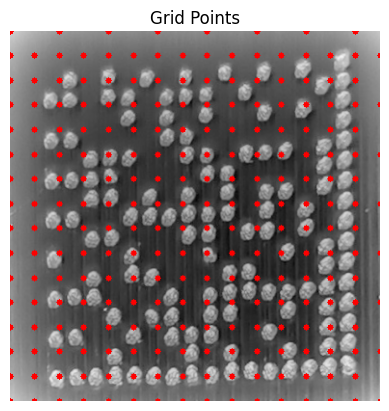

Cost value (naive start): 50126.42891021911


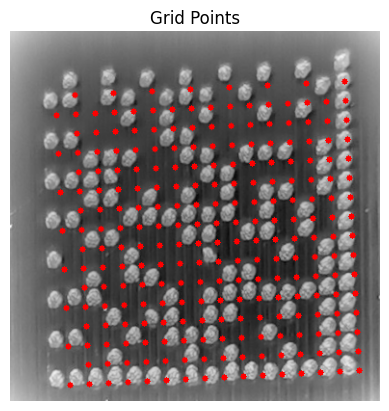

Cost value (estimated start): 39501.56456446438


In [19]:
def cost(params, observed_points, N, alpha):
    """
    Cost function for optimization. It computes the mean squared distance between observed points and grid points.
    The loss function is robust to outliers by focusing on the N closest points.

    Args:
        params: Parameters for grid (x0, y0, sx, sy, theta)
        observed_points: Observed points (numpy array)
        N: Number of closest points to consider for cost function
        alpha: Weighting factor for the cost function
    
    Returns:
        Mean squared distance between observed points and grid points.
    """
    grid_points = generate_grid(params)

    center = np.mean(observed_points, axis=0)
    distances_from_center = np.linalg.norm(observed_points - center, axis=1)
    
    # compute weights based on distance from center
    mean_distance = np.mean(distances_from_center)
    normalized_distances = distances_from_center / mean_distance
    weights = normalized_distances ** alpha

    # normalize weights to have mean 1
    weights = weights / np.mean(weights)

    all_N_closest_dists = []
    for i, obs_point in enumerate(observed_points):
        # finding N closest dists to point
        dists = np.linalg.norm(obs_point - grid_points, axis=1)
        sorted_dists = np.sort(dists)
        closest_dists = sorted_dists[:N]

        # 
        weighted_squared_dist = weights[i] * (closest_dists ** 2)
        all_N_closest_dists.extend(weighted_squared_dist)

    cost_ = np.mean(all_N_closest_dists)

    return cost_

# === Example usage of cost function ===
img = reflectance
nms_boxes = [(x, y, w, h) for (x, y, w, h) in nms_boxes]
N = 1000 # number of closest points to consider for cost function (higher = better, but slower)
alpha = 1.0

# cost of grid covering entire image
params = [
    img.shape[0] / 2, # x0
    img.shape[0] / 2, # y0
    img.shape[0] / 15, # sx
    img.shape[0] / 15, # sy
    0.0 # theta
]
grid_pts = generate_grid(params)
show_grid(img, grid_pts)
observed_pts = np.array([[x + w / 2, y + h / 2] for (x, y, w, h) in nms_boxes])
cost_value = cost(params, observed_pts, N, alpha)
print(f"Cost value (naive start): {cost_value}")

init_params, observed_pts = estimate_grid_params(nms_boxes, debug=False)
grid_pts = generate_grid(init_params)
show_grid(img, grid_pts)
cost_value = cost(init_params, observed_pts, N, alpha)
print(f"Cost value (estimated start): {cost_value}")

In [20]:
def cost_xy(xy, params, observed_pts, N, alpha):
    """
    Wrapper function for cost function. It takes the xy coordinates and the rest of the parameters separately.
    Used for optimizing x0 and y0.

    Args:
        xy: X and Y coordinates of the center of the grid
        params: Parameters for grid (sx, sy, theta)
    
    Returns:
        Mean squared distance between observed points and grid points.
    """
    x0, y0 = xy
    sx, sy, theta = params
    return cost([x0, y0, sx, sy, theta], observed_pts, N, alpha)

def cost_sx_sy(sx_sy, params, observed_pts, N, alpha):
    """
    Wrapper function for cost function. It takes the sx and sy coordinates and the rest of the parameters separately.
    Used for optimizing sx and sy.

    Args:
        sx_sy: Scale factors in the X and Y directions
        params: Parameters for grid (x0, y0, theta)
    
    Returns:
        Mean squared distance between observed points and grid points.
    """
    sx, sy = sx_sy
    x0, y0, theta = params
    return cost([x0, y0, sx, sy, theta], observed_pts, N, alpha)

def cost_theta(theta, params, observed_pts, N, alpha):
    """
    Wrapper function for cost function. It takes the theta coordinate and the rest of the parameters separately.
    Used for optimizing theta.

    Args:
        theta: Rotation angle in radians
        params: Parameters for grid (x0, y0, sx, sy)
    
    Returns:
        Mean squared distance between observed points and grid points.
    """
    theta = theta[0]  # Extract the single value from the array
    x0, y0, sx, sy = params
    return cost([x0, y0, sx, sy, theta], observed_pts, N, alpha)

Initial parameters: [205.068345323741, 210.03956834532374, 20.0, 20.0, 1.62]


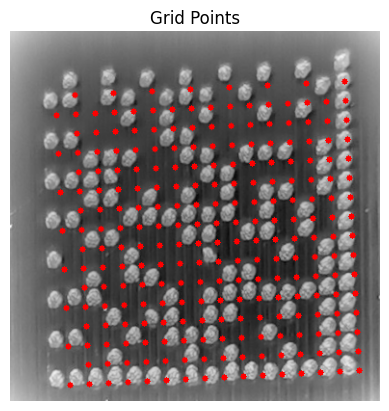

Better initial theta found: 1.62
Cost value: 147.04055905536762


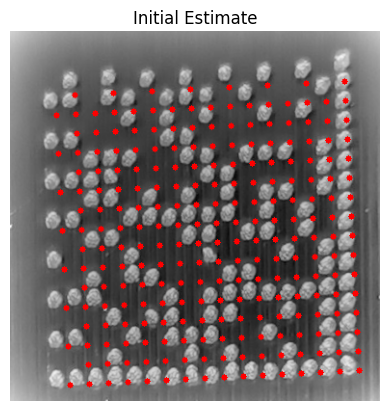

Optimized x0, y0: 195.14430607102793, 200.6436942924354
Cost value: 44.40788059129791


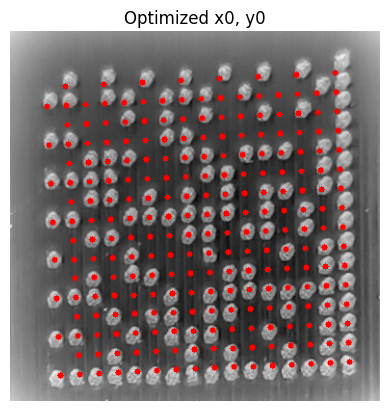

Optimized sx, sy: 20.773039331977994, 20.26626031479264
Cost value: 20.10001569112075


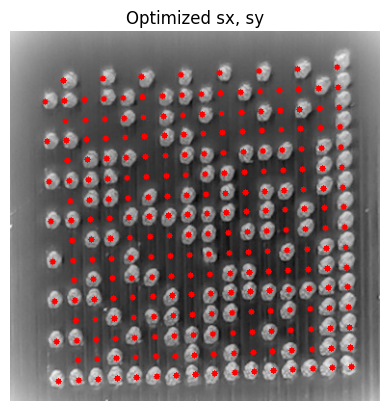

Optimized theta: 1.6076382193966239
Cost value: 15.14178294679238


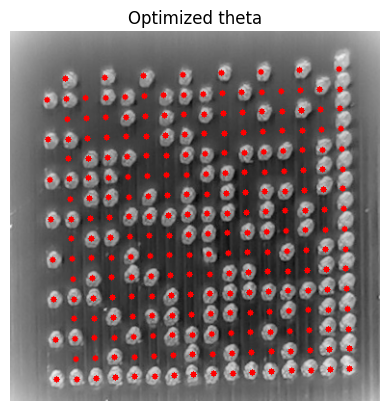

Optimized all: 195.04598953584872, 200.1804586216894, 20.788491322722997, 20.249842349445316, 1.6075692003426179
Cost value: 14.893936377423758


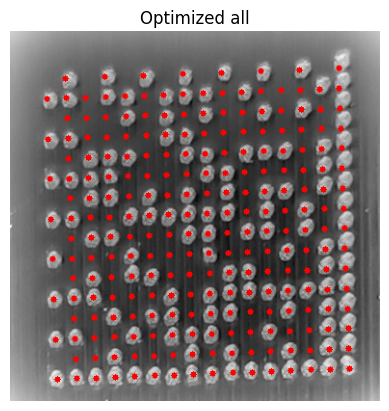

In [21]:
def estimate_grid(init_params, observed_pts, img, N, alpha, debug=False):
    """
    Estimates the grid parameters using optimization. The function optimizes the parameters
    (x0, y0, sx, sy, theta) to minimize the cost function based on the observed points.

    The optimization is done in the following order:
    1. Optimize x0 and y0
    2. Optimize sx and sy
    3. Optimize theta
    4. Optimize all parameters together

    Args:
        init_params: Initial parameters for the grid (x0, y0, sx, sy, theta)
        observed_pts: Observed points (numpy array)
        img: Input image (numpy array)
        N: Number of closest points to consider for cost function
        alpha: Weighting factor for the cost function
        debug: If True, display debug information (default is False)
    
    Returns:
        Optimized parameters (x0, y0, sx, sy, theta) and the observed points.
    """
    x0, y0, sx, sy, theta = init_params

    # 0. check for better initial theta
    # trying other 3 90 degree angles to see if they are better
    lowest_cost = cost([x0, y0, sx, sy, theta], observed_pts, N, alpha)
    for i in range(1, 4):
        theta_tmp = (theta + i * np.pi / 2) % (2 * np.pi)
        theta_tmp_cost = cost([x0, y0, sx, sy, theta_tmp], observed_pts, N, alpha)
        if theta_tmp_cost < lowest_cost:
            lowest_cost = theta_tmp_cost
            theta = theta_tmp
    if debug:
        print(f"Better initial theta found: {theta}")
        print(f"Cost value: {cost([x0, y0, sx, sy, theta], observed_pts, N, alpha)}")
        show_grid(img, generate_grid([x0, y0, sx, sy, theta]), title="Initial Estimate")

    # 1. optimize for x0, y0 only
    result = minimize(cost_xy, [x0, y0], args=([sx, sy, theta], observed_pts, N, alpha), method='Powell')
    x0, y0 = result.x
    if debug:
        print(f"Optimized x0, y0: {x0}, {y0}")
        print(f"Cost value: {cost([x0, y0, sx, sy, theta], observed_pts, N, alpha)}")
        show_grid(img, generate_grid([x0, y0, sx, sy, theta]), title="Optimized x0, y0")
    
    # 2. optimize for sx, sy only
    result = minimize(cost_sx_sy, [sx, sy], args=([x0, y0, theta], observed_pts, N, alpha), method='Powell')
    sx, sy = result.x
    if debug:
        print(f"Optimized sx, sy: {sx}, {sy}")
        print(f"Cost value: {cost([x0, y0, sx, sy, theta], observed_pts, N, alpha)}")
        show_grid(img, generate_grid([x0, y0, sx, sy, theta]), title="Optimized sx, sy")

    # 3. optimize for theta only
    result = minimize(cost_theta, [theta], args=([x0, y0, sx, sy], observed_pts, N, alpha), method='Powell')
    theta = result.x[0]
    # trying other 3 90 degree angles to see if they are better
    lowest_cost = cost([x0, y0, sx, sy, theta], observed_pts, N, alpha)
    for i in range(1, 4):
        theta_tmp = (theta + i * np.pi / 2) % (2 * np.pi)
        theta_tmp_cost = cost([x0, y0, sx, sy, theta_tmp], observed_pts, N, alpha)
        if theta_tmp_cost < lowest_cost:
            if debug:
                print(f"Found better theta: {theta_tmp} with cost: {theta_tmp_cost}. (previous: {theta} with cost: {lowest_cost})")
            lowest_cost = theta_tmp_cost
            theta = theta_tmp
    if debug:
        print(f"Optimized theta: {theta}")
        print(f"Cost value: {cost([x0, y0, sx, sy, theta], observed_pts, N, alpha)}")
        show_grid(img, generate_grid([x0, y0, sx, sy, theta]), title="Optimized theta")

    # 4. optimize for all parameters together
    result = minimize(cost, [x0, y0, sx, sy, theta], args=(observed_pts, N, alpha), method='Powell')
    x0, y0, sx, sy, theta = result.x
    if debug:
        print(f"Optimized all: {x0}, {y0}, {sx}, {sy}, {theta}")
        print(f"Cost value: {cost([x0, y0, sx, sy, theta], observed_pts, N, alpha)}")
        show_grid(img, generate_grid([x0, y0, sx, sy, theta]), title="Optimized all")

    return [x0, y0, sx, sy, theta], observed_pts

# === Example usage of grid estimation ===
N = 1
alpha = 5.0 # weight for cost function

init_params, observed_pts = estimate_grid_params(nms_boxes, debug=False)
print(f"Initial parameters: {init_params}")
grid_pts = generate_grid(init_params)
show_grid(img, grid_pts)
opt_params, observed_pts = estimate_grid(init_params, observed_pts, img, N, alpha, debug=True)

# Decoding

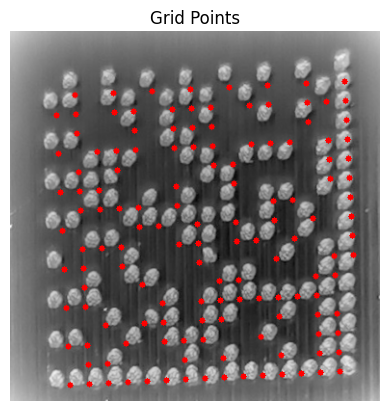

In [22]:
def map_observed_to_grid(observed_pts, grid_pts):
    """
    Maps observed points to grid points using the Hungarian algorithm to ensure 1-1 mapping.

    Args:
        observed_pts: Observed points (numpy array)
        grid_pts: Grid points (numpy array)
    
    Returns:
        Mapped grid points (numpy array)
    """
    cost_matrix = cdist(observed_pts, grid_pts, metric='euclidean')
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    mapped_grid_pts = grid_pts[col_ind]
    return mapped_grid_pts

# === Example usage of mapping observed points to grid points ===
# img = cv2.imread(img_to_test, cv2.IMREAD_GRAYSCALE)
# img = cv2.resize(img, (320, 320))
img = reflectance
nms_boxes = [(x, y, w, h) for (x, y, w, h) in nms_boxes]
init_params, observed_pts = estimate_grid_params(nms_boxes, debug=False)
grid_pts = generate_grid(init_params)
mapped_grid_pts = map_observed_to_grid(observed_pts, grid_pts)
show_grid(img, mapped_grid_pts)

In [23]:
def to_dmc_matrix(dmc_pts, grid_size=16):
    """
    Converts DMC points to a matrix representation.

    Args:
        dmc_pts: DMC points (numpy array)
        grid_size: Size of the grid (default is 16)
    
    Returns:
        DMC matrix (numpy array)
    """
    dmc_matrix = np.zeros((grid_size, grid_size), dtype=int)
    for pt in dmc_pts:
        x, y = pt
        dmc_matrix[y, x] = 1
    return dmc_matrix

# === Example usage of mapping to DMC points ===
# img = cv2.imread(img_to_test, cv2.IMREAD_GRAYSCALE)
# img = cv2.resize(img, (320, 320))
img = reflectance
nms_boxes = [(x, y, w, h) for (x, y, w, h) in nms_boxes]
init_params, observed_pts = estimate_grid_params(nms_boxes, debug=False)
grid_pts = generate_grid(init_params)
mapped_grid_pts = map_observed_to_grid(observed_pts, grid_pts)
dmc_pts = inverse_grid_transform(mapped_grid_pts, init_params)
dmc_matrix = to_dmc_matrix(dmc_pts)
print("DMC matrix:")
print(dmc_matrix)

DMC matrix:
[[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
 [1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1]
 [1 1 0 1 0 0 0 1 0 1 1 0 1 0 0 0]
 [1 0 1 0 0 0 1 1 0 1 0 1 1 0 1 1]
 [1 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0]
 [1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1]
 [1 1 1 0 0 0 0 1 0 1 1 0 1 1 1 0]
 [1 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1]
 [1 1 0 1 1 1 0 0 0 0 0 1 1 1 1 0]
 [1 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1]
 [1 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0]
 [1 1 0 1 1 0 1 0 1 1 0 0 1 0 1 1]
 [1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0]
 [1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 1]
 [1 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]]


In [24]:
def display_DMC(matrix, title="DMC Matrix"):
    """
    Display the DMC matrix like normal DMC.

    Args:
        matrix: Numpy array representing the DMC matrix
        title: Title of the plot (default is "DMC Matrix")
    """
    # Invert the matrix for display
    matrix = np.invert(matrix)
    plt.imshow(matrix, cmap='gray', interpolation='nearest')
    plt.title(title)
    plt.axis("off")
    plt.show()

In [25]:
def decode_DMC(matrix):
    """
    Decodes the DMC matrix using pylibdmtx.

    Args:
        matrix: Numpy array representing the DMC matrix
    
    Returns:
        Decoded string if successful, None otherwise.
    """
    # Converting binary matrix to uint8 image
    image = np.zeros((matrix.shape[0], matrix.shape[1]), dtype=np.uint8)
    image[matrix == 1] = 255
    image = Image.fromarray(image, 'L')

    # Inverting the image for decoding
    image = Image.eval(image, lambda x: 255 - x)

    # Padding the image by 2 pixels to add margin larger than a DMC module (https://www.keyence.eu/ss/products/auto_id/codereader/basic_2d/datamatrix.jsp)
    image = np.pad(np.array(image), ((2, 2), (2, 2)), mode='constant', constant_values=255)
    image = Image.fromarray(image, 'L')

    # Resizing to larger image for better decoding
    image = image.resize((image.size[0] * 10, image.size[1] * 10), Image.NEAREST)

    # Decode using pylibdmtx
    decoded = decode(image)
    if decoded:
        return decoded[0].data.decode('utf-8')
    else:
        return None

# Example of Grid Fitting Followed by Decoding

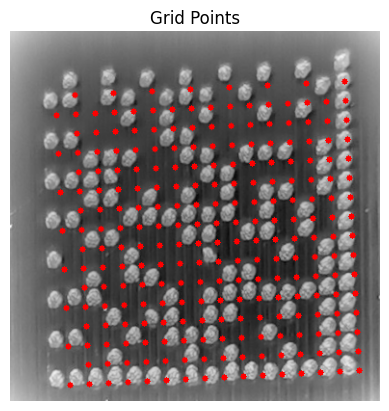

In [26]:
# === Estimate initial grid parameters ===
init_params, observed_pts = estimate_grid_params(nms_boxes)
grid_pts = generate_grid(init_params)
show_grid(img, grid_pts)

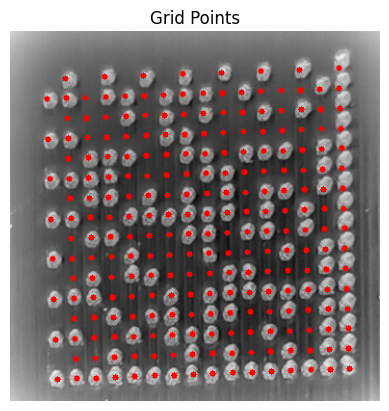

In [27]:
# === Optimize grid parameters ===
opt_params, observed_pts = estimate_grid(init_params, observed_pts, img, N, alpha)
grid_pts = generate_grid(opt_params)
show_grid(img, grid_pts)

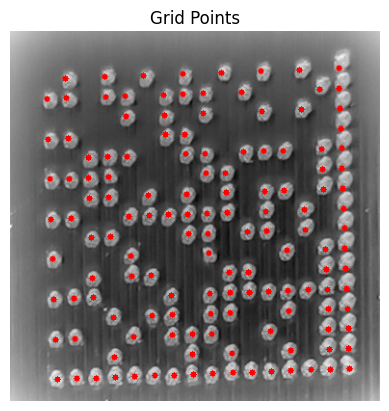

In [28]:
# === Mapping observed points to grid points ===
mapped_grid_pts = map_observed_to_grid(observed_pts, grid_pts)
show_grid(img, mapped_grid_pts)

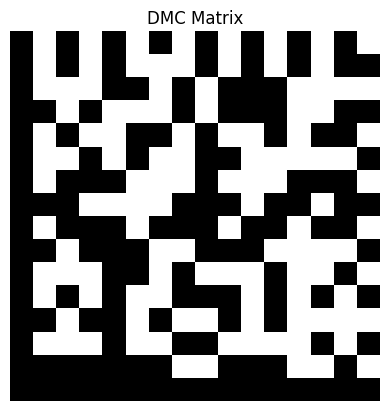

In [29]:
# === Convert to DMC matrix ===
dmc_pts = inverse_grid_transform(mapped_grid_pts, opt_params)
dmc_matrix = to_dmc_matrix(dmc_pts)
display_DMC(dmc_matrix)

In [30]:
# === Decoding DMC ===
decoded_data = decode_DMC(dmc_matrix)
print(decoded_data)

1D1I65212740006


# Full Decoding Pipeline

YOLO11n-obb summary (fused): 257 layers, 2,654,113 parameters, 0 gradients, 6.6 GFLOPs


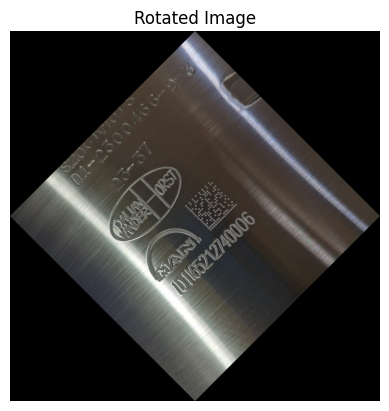

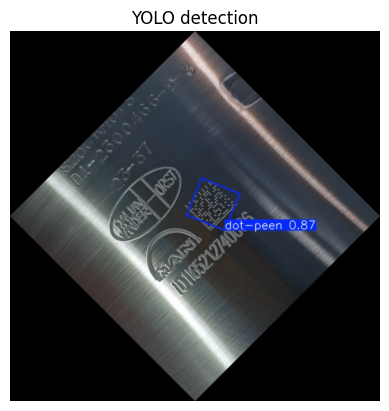

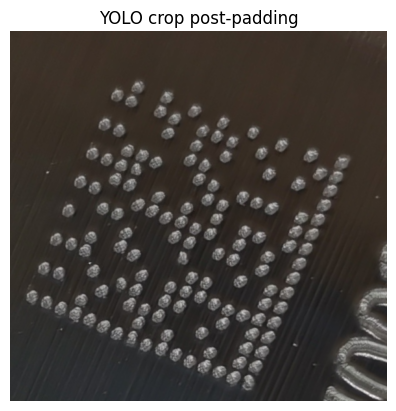

Image shape after YOLO crop: torch.Size([1, 3, 570, 581])


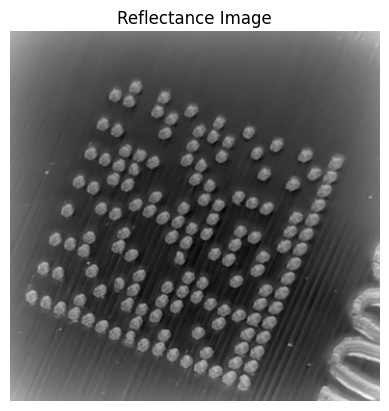

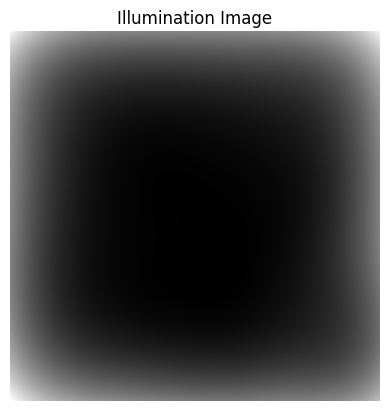

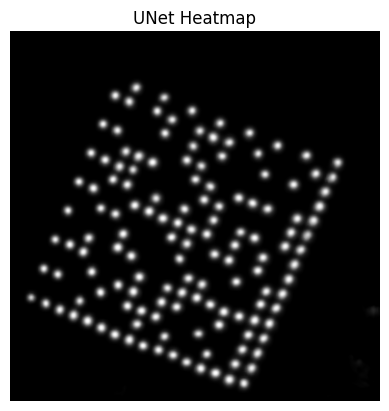

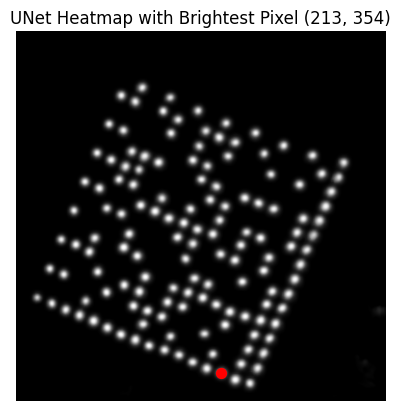

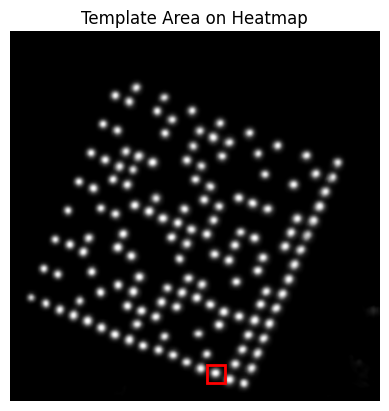

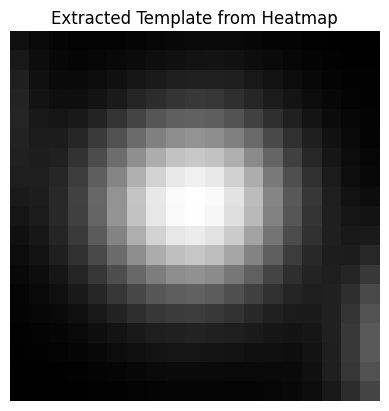

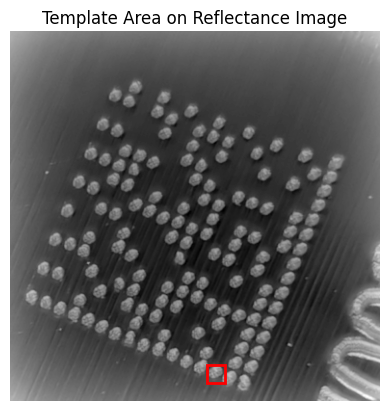

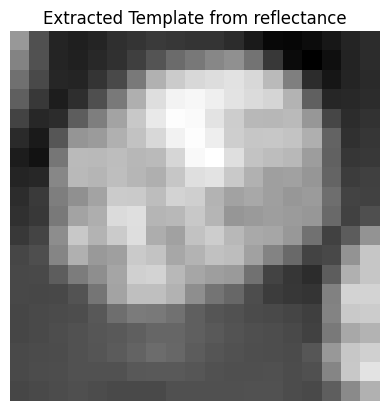

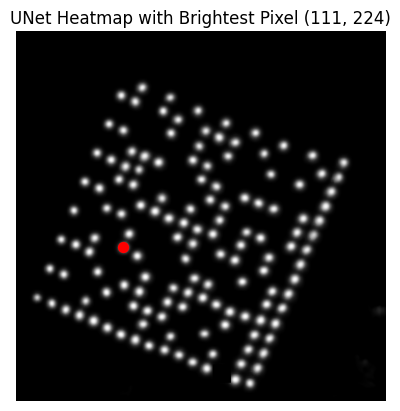

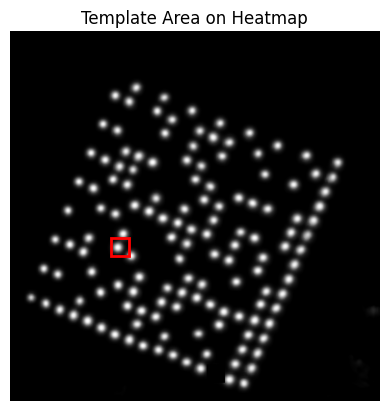

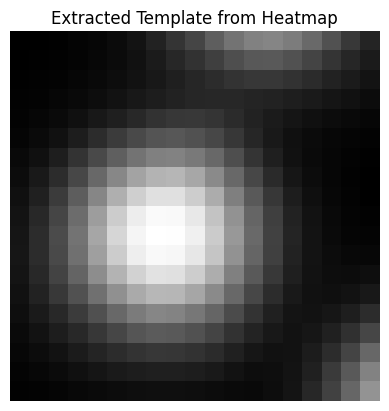

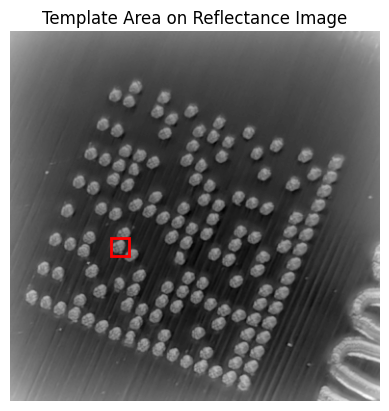

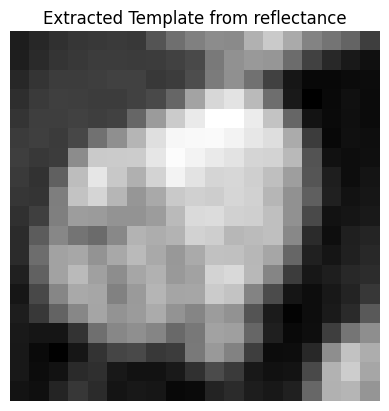

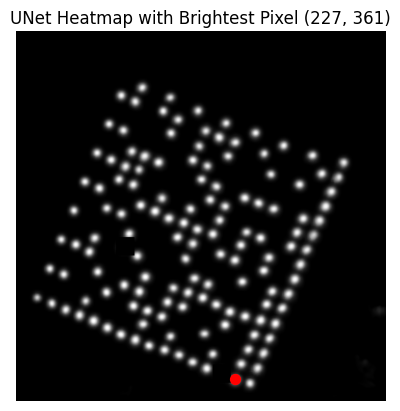

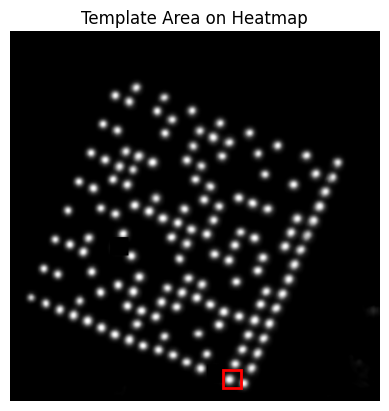

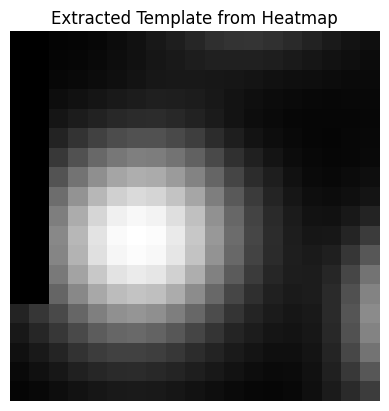

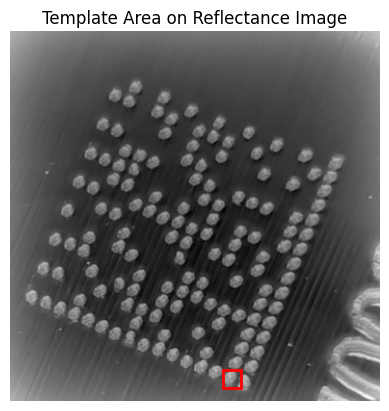

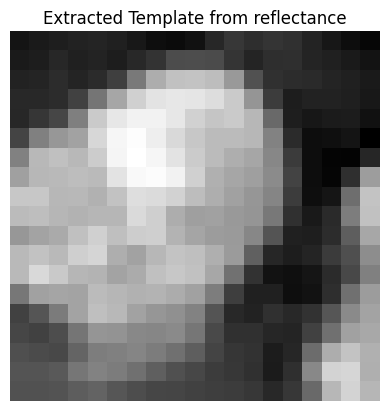

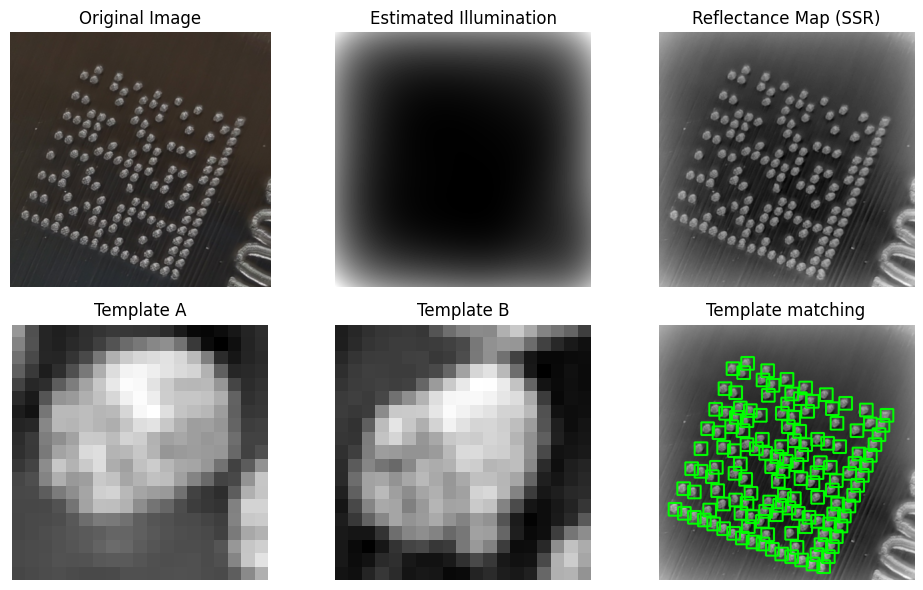

Estimated x, y: (185.8021582733813, 218.55755395683454)
Modal distance between (close) points: 16.16
Estimated sx & sy: 16.16, 16.16
Estimated theta: -0.35
Initial parameters: [185.8021582733813, 218.55755395683454, 16.16, 16.16, -0.35]
Better initial theta found: 2.7915926535897935
Cost value: 66.94063406958837


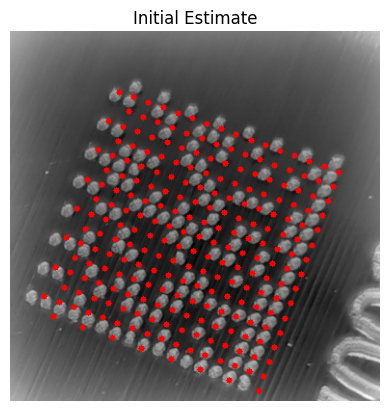

Optimized x0, y0: 183.07579150969934, 220.66566342156622
Cost value: 63.43781743161083


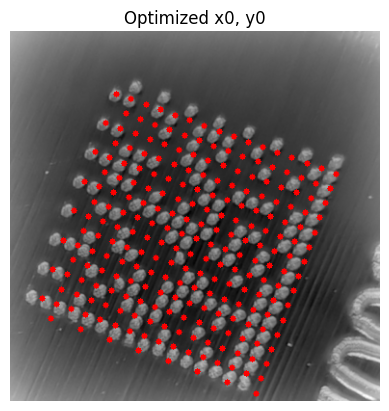

Optimized sx, sy: 16.320791623495587, 17.394095697917216
Cost value: 41.783092717987884


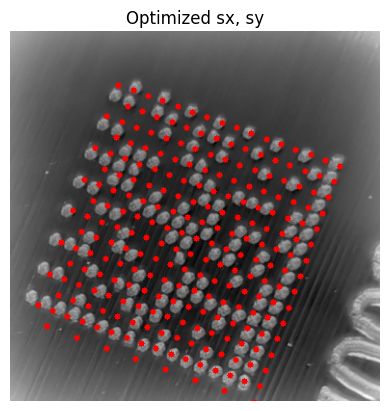

Optimized theta: 2.7994640313996344
Cost value: 40.85746077355902


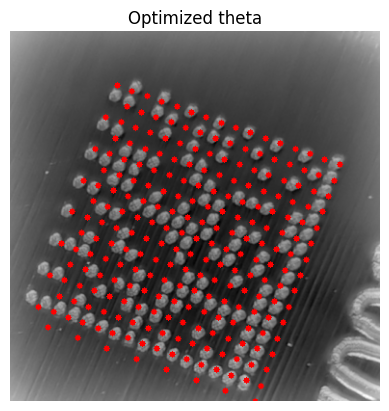

Optimized all: 183.80156050508674, 219.88688949654684, 16.27428594730958, 17.38614308987668, 2.801367017816944
Cost value: 40.13945340949633


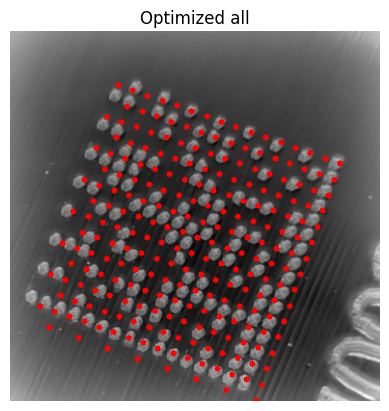

Mapped grid points


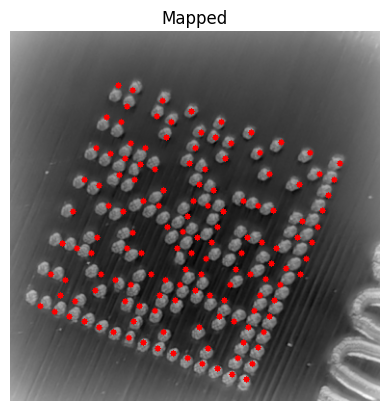

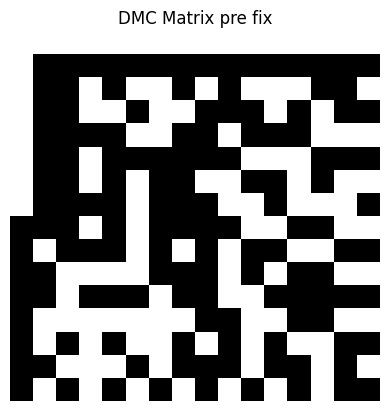

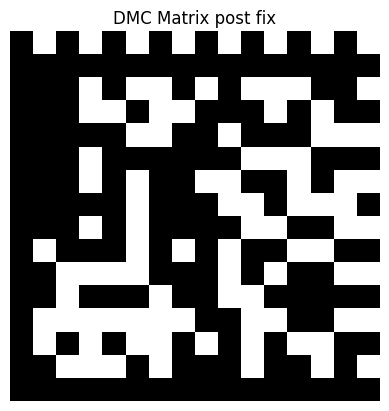

Decoded data: None


In [32]:
def decode_pipeline(image_path, yolo_model, unet_model, yolo_pad, tm_method=cv2.TM_CCOEFF_NORMED, tmm_thresh=0.7, nms_thresh=0.3, k_templates=3, N=1, alpha=4.0, debug=False, rotation=None):
    """
    Performs the entire decoding pipeline on the input image and template.

    Args:
        image_path: Path to the input image
        yolo_model: YOLO model for object detection
        unet_model: UNet model for template extraction
        yolo_pad: Padding for YOLO detection
        tm_method: Method for template matching (default is cv2.TM_CCOEFF_NORMED)
        tmm_thresh: Threshold for template matching (default is 0.7)
        nms_thresh: Threshold for non-maximum suppression (default is 0.3)
        k_templates: Number of templates to use (default is 3)
        N: Number of closest points to consider for cost function (default is 1)
        alpha: Weighting factor for the cost function (default is 4.0)
        debug: Flag for debugging (default is False)
        rotation: Rotation angle in degrees (default is None, no rotation)
    
    Returns:
        Decoded data from the DMC matrix or None if decoding fails.
    """
    # === Load image ===
    img = load_image_to_device(image_path)

    # === Rotation ===
    if rotation is not None:
        _, _, h, w = img.shape
        center = (w / 2, h / 2)

        # rotation matrix
        M = cv2.getRotationMatrix2D(center, rotation, 1)

        # getting size of new box to avoid cutting off corners
        cos = np.abs(M[0, 0])
        sin = np.abs(M[0, 1])
        new_w = int(h * sin + w * cos)
        new_h = int(h * cos + w * sin)

        # adjusting the rotation matrix to take into account translation
        M[0, 2] += new_w / 2 - center[0]
        M[1, 2] += new_h / 2 - center[1]

        # temporarily convert tensor to cv2 image
        img = img.squeeze(0).permute(1, 2, 0).cpu().numpy() # (H, W, 3)

        # rotating with new bounds
        img = cv2.warpAffine(img, M, (new_w, new_h))

        if debug:
            plt.imshow(img)
            plt.title("Rotated Image")
            plt.axis("off")
            plt.show()

        # converting back to tensor
        img = img.astype(np.float32)
        img = np.transpose(img, (2, 0, 1))
        img = torch.from_numpy(img).unsqueeze(0).to(device)

    # === YOLO crop ===
    img_yolo = yolo_detect_and_crop(img, yolo_model, yolo_pad, debug=debug)
    print(f"Image shape after YOLO crop: {img_yolo.shape}")

    # === UNet template ===
    reflectance, illumination, templates = unet_get_template(img_yolo, unet_model, k_templates, debug=debug)
    if reflectance is None or illumination is None or templates is None:
        print("UNet failed to get templates, returning None...")
        return None

    # === Template matching ===
    nms_boxes = cascade_template_matching(reflectance, templates, method=tm_method, match_thresh=tmm_thresh, nms_thresh=nms_thresh, k_templates=k_templates, debug=debug)

    if debug:
        display_yucheng_methods(nms_boxes, reflectance, img_yolo.squeeze(0).permute(1, 2, 0).cpu().numpy(), illumination, templates[0], templates[1])

    if len(nms_boxes) >= 16*16:
        print(f"Template matching found too many matches ({len(nms_boxes)}) returning None...")
        return None

    # === Estimate initial grid parameters ===
    init_params, observed_pts = estimate_grid_params(nms_boxes, debug)
    # if debug:
    #     grid_pts = generate_grid(init_params)
    #     show_grid(reflectance, grid_pts, title="Initial Estimate")

    # === Optimizing Grid Parameters ===
    opt_params, observed_pts = estimate_grid(init_params, observed_pts, reflectance, N, alpha, debug)
    grid_pts = generate_grid(opt_params)

    # === Mapping observed points to grid points ===
    mapped_grid_pts = map_observed_to_grid(observed_pts, grid_pts)
    if debug:
        print(f"Mapped grid points")
        show_grid(reflectance, mapped_grid_pts, title="Mapped")

    # === Convert to DMC matrix ===
    dmc_pts = inverse_grid_transform(mapped_grid_pts, opt_params)
    dmc_matrix = to_dmc_matrix(dmc_pts)
    if debug:
        display_DMC(dmc_matrix, title="DMC Matrix pre fix")

    # === Extra fix for finder patter ===
    dmc_matrix[:, 0] = 1  # left finder pattern
    dmc_matrix[-1, :] = 1 # bottom finder pattern
    for i in range(0, 16, 2):
        dmc_matrix[0, i] = 1  # top finder pattern 1s
        dmc_matrix[i, -1] = 0 # right finder pattern 0s
    for i in range(1, 16, 2):
        dmc_matrix[0, i] = 0  # top finder pattern 0s
        dmc_matrix[i, -1] = 1 # right finder pattern 1s
    if debug:
        display_DMC(dmc_matrix, title="DMC Matrix post fix")

    # === Decoding DMC ===
    decoded_data = decode_DMC(dmc_matrix)
    if debug:
        print(f"Decoded data: {decoded_data}")

    return decoded_data

img_to_test = '../data/MAN/raw/train/1D1165212740006.jpeg'

yolo_pad = 0.02 # % to pad the yolo crop by
yolo_model = load_yolo('../yolo/runs/obb/train4/weights/best.pt')

unet_model = load_unet('../models/dot_detection/checkpoints/unet_best.pth')

tm_method = cv2.TM_CCOEFF_NORMED # method for template matching
tmm_thresh = 0.7 # threshold for template matching (higher = more strict matching)
nms_thresh = 0.3 # threshold for non-maximum suppression (higher = more overlap)
k_templates = 3  # number of templates to use for cascade template matching

N = 1            # number of closest points to consider for cost function
alpha = 4        # weight for cost function (higher = more weight on points away from center)

decoded_data = decode_pipeline(img_to_test, yolo_model, unet_model, yolo_pad, tm_method, tmm_thresh, nms_thresh, k_templates, N, alpha, debug=True, rotation=45)

# Testing Full Pipeline (Train / Val data)

In [33]:
# === Pipeline Params ===
# yolo
yolo_model = load_yolo('../yolo/runs/obb/train4/weights/best.pt')
yolo_pad = 0.02 # % to pad the yolo crop by

# unet
unet_model = load_unet('../models/dot_detection/checkpoints/unet_best.pth')
k_templates = 3  # number of templates to use for unet template extraction + cascade template matching

# template matching
tm_method = cv2.TM_CCOEFF_NORMED # method for template matching
tmm_thresh = 0.7 # threshold for template matching (higher = more strict matching)
nms_thresh = 0.3 # threshold for non-maximum suppression (higher = more overlap)

# grid estimation
N = 1            # number of closest points to consider for cost function
alpha = 4.0      # weight for cost function (higher = more weight on points away from center)

# images to test
imgs_path = '../data/dot_detection/MAN/train-val-data/'
imgs = []
for filename in os.listdir(imgs_path):
    imgs.append(os.path.join(imgs_path, filename))

YOLO11n-obb summary (fused): 257 layers, 2,654,113 parameters, 0 gradients, 6.6 GFLOPs


In [34]:
my_method = 0
pylibdmtx_method = 0
for filename in imgs:
    decoded_data = decode_pipeline(filename, yolo_model, unet_model, yolo_pad, tm_method, tmm_thresh, nms_thresh, k_templates, N, alpha, debug=False)
    if type(decoded_data) == str:
        my_method += 1

    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    decoded_data = decode(img) # pylibdmtx method
    if decoded_data:
        pylibdmtx_method += 1

print(f"MY METHOD: {my_method}/{len(imgs)}")
print(f"PYLIBDMTX METHOD: {pylibdmtx_method}/{len(imgs)}")

Image shape after YOLO crop: torch.Size([1, 3, 502, 509])
Image shape after YOLO crop: torch.Size([1, 3, 606, 654])
Image shape after YOLO crop: torch.Size([1, 3, 668, 691])
Template matching found too many matches (281) returning None...
Image shape after YOLO crop: torch.Size([1, 3, 799, 802])
Image shape after YOLO crop: torch.Size([1, 3, 57, 101])
Image shape after YOLO crop: torch.Size([1, 3, 84, 145])
Template matching found too many matches (414) returning None...
YOLO did not detect any objects.
WARNING, no object detected, returning original image
Image shape after YOLO crop: torch.Size([1, 3, 1334, 750])
No contours found in the binary mask.
UNet failed to get templates, returning None...
Image shape after YOLO crop: torch.Size([1, 3, 437, 971])
No contours found in the binary mask.
UNet failed to get templates, returning None...
Image shape after YOLO crop: torch.Size([1, 3, 461, 476])
Template matching found too many matches (398) returning None...
Image shape after YOLO cr